# Quora Questions Classification Based on Word Vectors
## using Spacy with vectors only statistical model en_vectors_web_lg
## and Vowpal Wabbit with Hinge loss function


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORKING_DIR = os.path.join('.input', 'hinge_spacy_vectors')

In [3]:
quora = pd.read_csv('../data/.input/train.csv')

In [4]:
quora.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [5]:
quora_train, quora_test = train_test_split(quora, random_state=42)
quora_train_data = quora_train.question_text
quora_train_labels = quora_train.target * 2.0 - 1.0
quora_test_data = quora_test.question_text
quora_test_labels = quora_test.target * 2.0 - 1.0

In [8]:
%%time

import spacy
nlp = spacy.load('en_vectors_web_lg')

Wall time: 28.8 s


In [12]:
def vectorize_text(text):
    doc = nlp(text)
    return doc.vector

def to_vw_format(document, label=None):
    vector = vectorize_text(document)
    values = []
    for index, value in enumerate(vector):
        values.append('f{}:{}'.format(index, value))
    return str(label or '') + ' |n ' + ' '.join(values) + '\n'

to_vw_format(quora_train_data.iloc[0], quora_train_labels[0])[:70]

'-1.0 |n f0:-0.011226640082895756 f1:0.0914510041475296 f2:-0.168460875'

In [13]:
!!mkdir $WORKING_DIR
trainDataPath = os.path.join(WORKING_DIR, 'train.vw')
testDataPath = os.path.join(WORKING_DIR, 'test.vw')
modelPath = os.path.join(WORKING_DIR, 'model.vw')
predictionsPath = os.path.join(WORKING_DIR, 'test_predictions.txt')
cachePath = os.path.join(WORKING_DIR, 'cache')

In [14]:
%%time

with open(trainDataPath, 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(quora_train_data, quora_train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(testDataPath, 'w', encoding='utf-8') as vw_test_data:
    for text, target in zip(quora_test_data, quora_test_labels):
        vw_test_data.write(to_vw_format(text, target))

Wall time: 31min 53s


In [68]:
!!vw -d $trainDataPath --cache_file $cachePath --loss_function hinge -f $modelPath

['final_regressor = .input\\logistic_spacy_vectors\\model.vw',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using cache_file = .input\\logistic_spacy_vectors\\cache',
 'ignoring text input in favor of cache input',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '1.000000 1.000000            1            1.0  -1.0000   0.0000      301',
 '0.500000 0.000000            2            2.0  -1.0000  -1.0000      301',
 '0.627500 0.754999            4            4.0  -1.0000  -0.4900      301',
 '0.434573 0.241646            8            8.0  -1.0000  -0.8616      301',
 '0.441100 0.447627           16           16.0  -1.0000  -1.0000      301',
 '0.248765 0.056430           32           32.0  -1.0000  -1.0000      301',
 '0.177735 0.106706           64           64.0  -1.0000  -0.8776      301',
 '0.160082 0.142428          1

In [69]:
!!vw -i $modelPath -t -d $testDataPath -p $predictionsPath

['only testing',
 'predictions = .input\\logistic_spacy_vectors\\test_predictions.txt',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'using no cache',
 'Reading datafile = .input\\logistic_spacy_vectors\\test.vw',
 'num sources = 1',
 'average  since         example        example  current  current  current',
 'loss     last          counter         weight    label  predict features',
 '0.000000 0.000000            1            1.0  -1.0000  -1.0000      301',
 '0.000000 0.000000            2            2.0  -1.0000  -1.0000      301',
 '0.000000 0.000000            4            4.0  -1.0000  -1.0000      301',
 '0.000000 0.000000            8            8.0  -1.0000  -1.0000      301',
 '0.000000 0.000000           16           16.0  -1.0000  -1.0000      301',
 '0.004598 0.009196           32           32.0  -1.0000  -1.0000      301',
 '0.025052 0.045506           64           64.0  -1.0000  -1.0000      301',
 '0.119519 0.213985          128

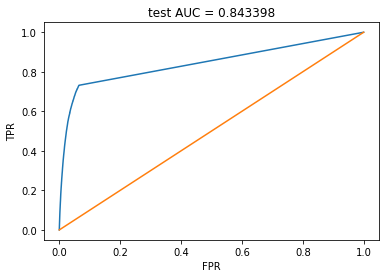

In [70]:
with open(predictionsPath) as pred_file:
    quora_test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(quora_test_labels, quora_test_prediction)
curve = roc_curve(quora_test_labels, quora_test_prediction)


plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);


In [71]:
quora_test_pred = list(map(lambda x: -1.0 if x < 0.0 else 1.0, quora_test_prediction))
print('accuracy', accuracy_score(quora_test_labels, quora_test_pred))
print('precision', precision_score(quora_test_labels, quora_test_pred))
print('recall', recall_score(quora_test_labels, quora_test_pred))
print('f1', f1_score(quora_test_labels, quora_test_pred))
confusion_matrix(quora_test_labels, quora_test_pred)

accuracy 0.944599440788164
precision 0.7116044861524377
recall 0.15592557299764281
f1 0.25580055948658875


array([[305332,   1260],
       [ 16830,   3109]], dtype=int64)